In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# loading the data
rbs = pd.read_csv('CombinedData/PlayerInfo/Running_Back.csv')
tes = pd.read_csv('CombinedData/PlayerInfo/Tight_End.csv')
wrs = pd.read_csv('CombinedData/PlayerInfo/Wide_Receiver.csv')

df = pd.concat([rbs, tes, wrs])
print(df.shape)
df.head()

(2822, 15)


,Date,Away Team,Home Team,Player,Player Team,Passing Yards,Passing TD,Passing INT,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost,Pos
0,2024-09-05,Baltimore Ravens,Kansas City Chiefs,derrick henry,Baltimore Ravens,0,0,0,0,0,0,46,1,0,RB
1,2024-09-05,Baltimore Ravens,Kansas City Chiefs,justice hill,Baltimore Ravens,0,0,0,6,52,0,3,0,0,RB
2,2024-09-05,Baltimore Ravens,Kansas City Chiefs,isiah pacheco,Kansas City Chiefs,0,0,0,2,33,0,45,1,0,RB
3,2024-09-05,Baltimore Ravens,Kansas City Chiefs,carson steele,Kansas City Chiefs,0,0,0,0,0,0,3,0,0,RB
4,2024-09-05,Baltimore Ravens,Kansas City Chiefs,samaje perine,Kansas City Chiefs,0,0,0,1,10,0,0,0,0,RB


In [3]:
# adding fantasy points for each player
points_per_rushing_yard = 0.1
points_per_rushing_td = 6
points_per_reception = 1
points_per_receiving_yard = 0.1
points_per_receiving_td = 6
points_per_fumble = -2

def get_player_points(row):
    points = 0
    points += row['Rushing Yards'] * points_per_rushing_yard
    points += row['Rushing TD'] * points_per_rushing_td
    points += row['Receptions'] * points_per_reception
    points += row['Receiving Yards'] * points_per_receiving_yard
    points += row['Receiving TD'] * points_per_receiving_td
    points += row['Fumbles Lost'] * points_per_fumble

    return points

df['Fantasy Points'] = df.apply(get_player_points, axis=1)

df.head()

,Date,Away Team,Home Team,Player,Player Team,Passing Yards,Passing TD,Passing INT,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost,Pos,Fantasy Points
0,2024-09-05,Baltimore Ravens,Kansas City Chiefs,derrick henry,Baltimore Ravens,0,0,0,0,0,0,46,1,0,RB,10.6
1,2024-09-05,Baltimore Ravens,Kansas City Chiefs,justice hill,Baltimore Ravens,0,0,0,6,52,0,3,0,0,RB,11.5
2,2024-09-05,Baltimore Ravens,Kansas City Chiefs,isiah pacheco,Kansas City Chiefs,0,0,0,2,33,0,45,1,0,RB,15.8
3,2024-09-05,Baltimore Ravens,Kansas City Chiefs,carson steele,Kansas City Chiefs,0,0,0,0,0,0,3,0,0,RB,0.3
4,2024-09-05,Baltimore Ravens,Kansas City Chiefs,samaje perine,Kansas City Chiefs,0,0,0,1,10,0,0,0,0,RB,2.0


In [4]:
# adding the next week fantasy points (and log transformed fantasy points)
df['Next Week Fantasy Points'] = df.groupby('Player')['Fantasy Points'].shift(-1)
df['Next Week Fantasy Points Log'] = np.log1p(df['Next Week Fantasy Points'])

print(df.shape)
df = df.dropna(subset=['Next Week Fantasy Points'])
df = df.dropna(subset=['Next Week Fantasy Points Log'])
print(df.shape)

df[df['Player'] == 'derrick henry']

(2822, 18)
(2405, 18)


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Date,Away Team,Home Team,Player,Player Team,Passing Yards,Passing TD,Passing INT,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost,Pos,Fantasy Points,Next Week Fantasy Points,Next Week Fantasy Points Log
0,2024-09-05,Baltimore Ravens,Kansas City Chiefs,derrick henry,Baltimore Ravens,0,0,0,0,0,0,46,1,0,RB,10.6,16.6,2.867899
103,2024-09-15,Las Vegas Raiders,Baltimore Ravens,derrick henry,Baltimore Ravens,0,0,0,1,12,0,84,1,0,RB,16.6,30.4,3.446808
159,2024-09-22,Baltimore Ravens,Dallas Cowboys,derrick henry,Baltimore Ravens,0,0,0,1,23,0,151,2,0,RB,30.4,35.9,3.608212
238,2024-09-29,Buffalo Bills,Baltimore Ravens,derrick henry,Baltimore Ravens,0,0,0,3,10,1,199,1,0,RB,35.9,16.6,2.867899
310,2024-10-06,Baltimore Ravens,Cincinnati Bengals,derrick henry,Baltimore Ravens,0,0,0,1,4,0,92,1,0,RB,16.6,25.2,3.265759
429,2024-10-13,Washington Commanders,Baltimore Ravens,derrick henry,Baltimore Ravens,0,0,0,0,0,0,132,2,0,RB,25.2,25.2,3.265759
497,2024-10-21,Baltimore Ravens,Tampa Bay Buccaneers,derrick henry,Baltimore Ravens,0,0,0,1,13,1,169,0,0,RB,25.2,14.7,2.753661
521,2024-10-27,Baltimore Ravens,Cleveland Browns,derrick henry,Baltimore Ravens,0,0,0,1,4,0,73,1,0,RB,14.7,26.3,3.306887
607,2024-11-03,Denver Broncos,Baltimore Ravens,derrick henry,Baltimore Ravens,0,0,0,1,27,0,106,2,0,RB,26.3,14.1,2.714695
658,2024-11-07,Cincinnati Bengals,Baltimore Ravens,derrick henry,Baltimore Ravens,0,0,0,1,3,0,68,1,0,RB,14.1,10.5,2.442347


In [5]:
# save data to csv
df.to_csv('offensiveplayers.csv', index=False)

### EDA

<Axes: >

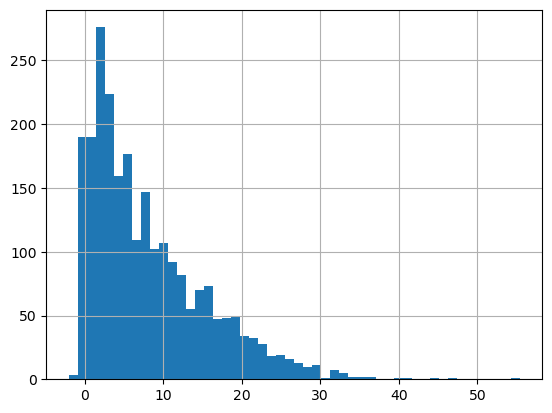

In [5]:
df['Fantasy Points'].hist(bins=50)

In [6]:
# applying a log transformation to Fantasy Points
df['Fantasy Points Log'] = np.log1p(df['Fantasy Points'])

df = df.drop(df[df['Fantasy Points'] == -1].index)

df.head()

c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Date,Away Team,Home Team,Player,Player Team,Passing Yards,Passing TD,Passing INT,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost,Pos,Fantasy Points,Next Week Fantasy Points,Next Week Fantasy Points Log,Fantasy Points Log
0,2024-09-05,Baltimore Ravens,Kansas City Chiefs,derrick henry,Baltimore Ravens,0,0,0,0,0,0,46,1,0,RB,10.6,16.6,2.867899,2.451005
1,2024-09-05,Baltimore Ravens,Kansas City Chiefs,justice hill,Baltimore Ravens,0,0,0,6,52,0,3,0,0,RB,11.5,5.2,1.824549,2.525729
2,2024-09-05,Baltimore Ravens,Kansas City Chiefs,isiah pacheco,Kansas City Chiefs,0,0,0,2,33,0,45,1,0,RB,15.8,16.1,2.839078,2.821379
3,2024-09-05,Baltimore Ravens,Kansas City Chiefs,carson steele,Kansas City Chiefs,0,0,0,0,0,0,3,0,0,RB,0.3,0.4,0.336472,0.262364
4,2024-09-05,Baltimore Ravens,Kansas City Chiefs,samaje perine,Kansas City Chiefs,0,0,0,1,10,0,0,0,0,RB,2.0,1.3,0.832909,1.098612


<Axes: >

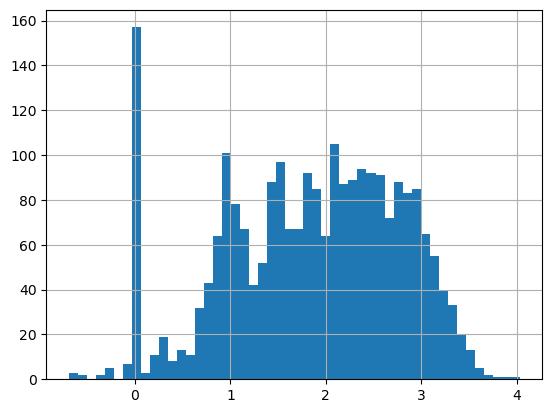

In [7]:
df['Fantasy Points Log'].hist(bins=50)

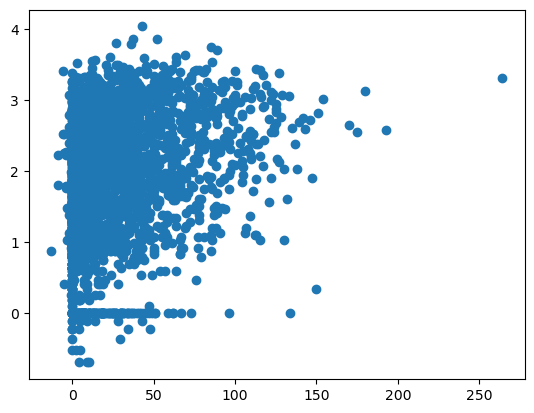

In [8]:
plt.scatter(df['Receiving Yards'], df['Next Week Fantasy Points Log'])

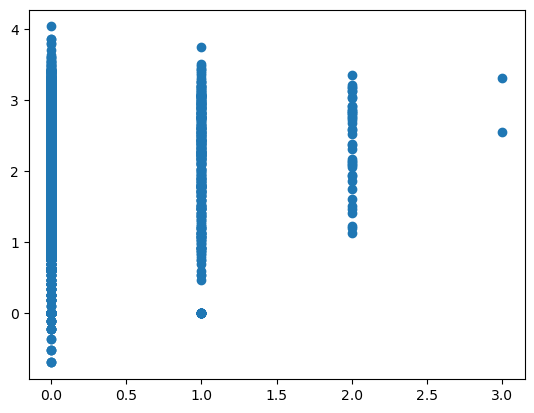

In [9]:
plt.scatter(df['Receiving TD'], df['Next Week Fantasy Points Log'])

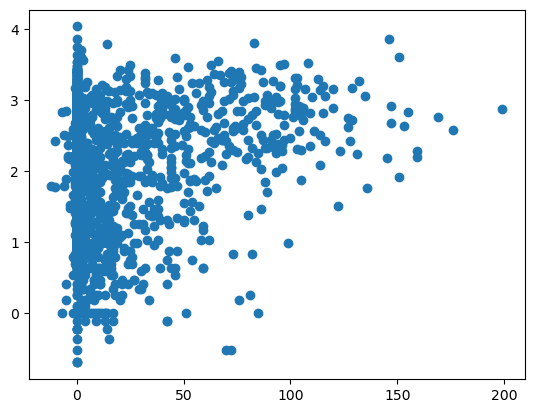

In [10]:
plt.scatter(df['Rushing Yards'], df['Next Week Fantasy Points Log'])

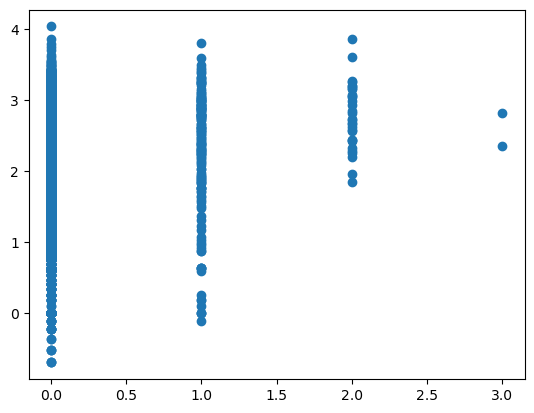

In [11]:
plt.scatter(df['Rushing TD'], df['Next Week Fantasy Points Log'])

### Creating XGB Model

In [12]:
df.head()

,Date,Away Team,Home Team,Player,Player Team,Passing Yards,Passing TD,Passing INT,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost,Pos,Fantasy Points,Next Week Fantasy Points,Next Week Fantasy Points Log,Fantasy Points Log
0,2024-09-05,Baltimore Ravens,Kansas City Chiefs,derrick henry,Baltimore Ravens,0,0,0,0,0,0,46,1,0,RB,10.6,16.6,2.867899,2.451005
1,2024-09-05,Baltimore Ravens,Kansas City Chiefs,justice hill,Baltimore Ravens,0,0,0,6,52,0,3,0,0,RB,11.5,5.2,1.824549,2.525729
2,2024-09-05,Baltimore Ravens,Kansas City Chiefs,isiah pacheco,Kansas City Chiefs,0,0,0,2,33,0,45,1,0,RB,15.8,16.1,2.839078,2.821379
3,2024-09-05,Baltimore Ravens,Kansas City Chiefs,carson steele,Kansas City Chiefs,0,0,0,0,0,0,3,0,0,RB,0.3,0.4,0.336472,0.262364
4,2024-09-05,Baltimore Ravens,Kansas City Chiefs,samaje perine,Kansas City Chiefs,0,0,0,1,10,0,0,0,0,RB,2.0,1.3,0.832909,1.098612


In [13]:
# only selecting the relevant features
pos_players = df[['Receptions', 'Receiving Yards', 'Receiving TD', 'Rushing Yards', 'Rushing TD', 'Fumbles Lost', 'Next Week Fantasy Points Log']]

pos_players.head()

,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost,Next Week Fantasy Points Log
0,0,0,0,46,1,0,2.867899
1,6,52,0,3,0,0,1.824549
2,2,33,0,45,1,0,2.839078
3,0,0,0,3,0,0,0.336472
4,1,10,0,0,0,0,0.832909


In [14]:
# handling infinite values
pos_players = pos_players.replace([np.inf, -np.inf], np.nan)

pos_players = pos_players.dropna()

In [15]:
X = pos_players.drop('Next Week Fantasy Points Log', axis=1)
y = pos_players[['Next Week Fantasy Points Log']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [16]:
y_train = y_train.replace([np.inf, -np.inf], np.nan).dropna()


In [17]:
model = xgb.XGBRegressor(objective ='reg:squarederror', seed=123)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [18]:
y_pred = model.predict(X_test)

mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
print('MSE: %.2f' % mse)

MSE: 58.36


## Bayesion Optimization

In [19]:
from bayes_opt import BayesianOptimization

class BayesianXGBOptimizer:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # Define hyperparameter bounds
        self.pbounds = {
            'max_depth': (3, 12),            # Tree depth
            'learning_rate': (0.01, 0.3),    # Learning rate
            'n_estimators': (100, 1000),     # Number of trees
            'min_child_weight': (1, 7),      # Minimum sum of instance weight in a child
            'gamma': (0, 0.5),               # Minimum loss reduction for partition
            'subsample': (0.6, 1.0),         # Subsample ratio of training instances
            'colsample_bytree': (0.6, 1.0),  # Subsample ratio of columns for each tree
        }
        
    def xgb_evaluate(self, max_depth, learning_rate, n_estimators, 
                    min_child_weight, gamma, subsample, colsample_bytree):
        """Evaluation function for Bayesian optimization"""
        params = {
            'max_depth': int(max_depth),
            'learning_rate': learning_rate,
            'n_estimators': int(n_estimators),
            'min_child_weight': min_child_weight,
            'gamma': gamma,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'objective': 'reg:squarederror',
            'random_state': 42
        }
        
        model = model = xgb.XGBRegressor(**params)
        model.fit(self.X_train, self.y_train)
        predictions = model.predict(self.X_test)
        mse = mean_squared_error(self.y_test, predictions)
        
        # Return negative MSE because Bayesian optimization maximizes
        return -mse
    
    def optimize(self, n_iter=50, init_points=5):
        """Run Bayesian optimization"""
        optimizer = BayesianOptimization(
            f=self.xgb_evaluate,
            pbounds=self.pbounds,
            random_state=42
        )
        
        optimizer.maximize(
            init_points=init_points,  # Number of initial random evaluations
            n_iter=n_iter             # Number of optimization iterations
        )
        
        # Get best parameters
        params = optimizer.max['params']
        params['max_depth'] = int(params['max_depth'])
        params['n_estimators'] = int(params['n_estimators'])
        
        # Train final model with best parameters
        final_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=42,
            **params
        )
        final_model.fit(self.X_train, self.y_train)
        
        return {
            'best_params': params,
            'best_score': -optimizer.max['target'],  # Convert back to MSE
            'model': final_model,
            'optimization_history': optimizer.space.target
        }
    

optimizer = BayesianXGBOptimizer(X_train, X_test, y_train, y_test)
results = optimizer.optimize(n_iter=50, init_points=5)

print('Best score: %.2f' % results['best_score'])
print('Best parameters:', results['best_params'])

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.8824   | 0.7498    | 0.4754    | 0.2223    | 8.388     | 1.936     | 240.4     | 0.6232    |
| 2         | -0.8773   | 0.9465    | 0.3006    | 0.2153    | 3.185     | 6.819     | 849.2     | 0.6849    |
| 3         | -0.9027   | 0.6727    | 0.0917    | 0.09823   | 7.723     | 3.592     | 362.1     | 0.8447    |
| 4         | -0.8659   | 0.6558    | 0.1461    | 0.1162    | 7.105     | 5.711     | 279.7     | 0.8057    |
| 5         | -0.9433   | 0.837     | 0.02323   | 0.1862    | 4.535     | 1.39      | 954.0     | 0.9863    |
| 6         | -0.7897   | 0.9606    | 0.06105   | 0.01253   | 4.486     | 6.936     | 791.5     | 0.8457    |
| 7         | -0.8385   | 0.856     | 0.2456    | 0.08917   | 3.987     | 6.305     | 791.2     | 0.8728    |
| 8       

In [20]:
model = results['model']

y_pred = model.predict(X_test)

mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
print('MSE: %.2f' % mse)

MSE: 49.79


In [22]:
# saving the model
model.save_model('offensive_players_model.json')

### Comparing predictions and actual values

In [23]:
X_test.head()

,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost
581,5,30,0,0,0,0
681,5,23,0,0,0,0
173,1,25,0,110,2,0
594,3,12,0,107,0,0
433,0,0,0,0,0,0


In [ ]:
predictions = model.predict(X_test.head())

print('Predicted Fantasy Points:', np.expm1(predictions))

Predicted Fantasy Points: [ 7.027094   7.118766  17.554184  13.296284   2.5854106]


In [35]:
temp_df = y_test.head()
temp_df['Next Week Fantasy Points'] = np.expm1(temp_df['Next Week Fantasy Points Log'])
temp_df['predictions'] = np.expm1(predictions)
temp_df['percent_difference'] = (temp_df['Next Week Fantasy Points'] - temp_df['predictions']) / temp_df['Next Week Fantasy Points']
temp_df

C:\Users\wolfgramml\AppData\Local\Temp\ipykernel_39872\1188303242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Next Week Fantasy Points'] = np.expm1(temp_df['Next Week Fantasy Points Log'])
C:\Users\wolfgramml\AppData\Local\Temp\ipykernel_39872\1188303242.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['predictions'] = np.expm1(predictions)
C:\Users\wolfgramml\AppData\Local\Temp\ipykernel_39872\1188303242.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,Next Week Fantasy Points Log,Next Week Fantasy Points,predictions,percent_difference
581,2.944439,18.0,7.027094,0.609606
681,2.617396,12.7,7.118766,0.439467
173,3.034953,19.8,17.554184,0.113425
594,3.148453,22.3,13.296284,0.403754
433,2.219203,8.2,2.585411,0.684706


In [31]:
input_data = pd.DataFrame([{
    'Receptions': 1,
    'Receiving Yards': 25,
    'Receiving TD': 0,
    'Rushing Yards': 110,
    'Rushing TD': 2,
    'Fumbles Lost': 0
}])

# Make prediction
prediction = model.predict(input_data)

print('Predicted Fantasy Points:', prediction[0])

Predicted Fantasy Points: 2.9206953
